# Specviz Simple Demo

**Use case:** This notebook demonstrates how to inspect spectra in Specviz, export spectra from the GUI in the notebook, select regions in the GUI and in the notebook, and measure the redshift of a source in the GUI.<br>
**Data:** NIRISS 1D spectra from the [NGDEEP survey](https://ui.adsabs.harvard.edu/abs/2023arXiv230205466B/abstract). The dataset has been processed with the default pipeline and is read from AWS.<br>
**Tools:** specutils, jdaviz, astropy.<br>
**Cross-intrument:** all instruments.<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>

**Updated on**: 2025/02/26 by Camilla Pacifici

Imports:
- matplotlib for plotting data
- astropy for handling of fits files, units, and tables
- specutils for interactions with Specviz and region definition/extraction
- jdaviz for the visualization tool Specviz
- astroquery to get the data from AWS

In [1]:
# Plotting and tabling
import matplotlib.pyplot as plt

# Import astropy
import astropy
import astropy.units as u
from astropy.io import fits
from astropy.table import QTable
from astropy.nddata import StdDevUncertainty

# Import specutils
import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region

# Import viztools
import jdaviz
from jdaviz import Specviz

# Astroquery
from astroquery.mast import Observations

In [2]:
# Customization of matplotlib style
plt.rcParams["figure.figsize"] = (10, 5)
params = {'legend.fontsize': '18', 'axes.labelsize': '18',
          'axes.titlesize': '18', 'xtick.labelsize': '18',
          'ytick.labelsize': '18', 'lines.linewidth': 2,
          'axes.linewidth': 2, 'animation.html': 'html5',
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

Check versions

In [3]:
print('astropy:', astropy.__version__)
print('specutils:', specutils.__version__)
print('jdaviz:', jdaviz.__version__)

astropy: 7.1.0
specutils: 1.20.3
jdaviz: 4.2.3


## 1. Load NIRISS pipeline output
We get the data directly from AWS by searching for proposal 2079 and NIRISS instrument in WFSS mode. The filename we are looking for is jw02079-o001_s000000680_niriss_f150w-gr150c_x1d.fits. Uncomment the line with `download_products` if you want to save a local copy of the file.

In [4]:
# Simply call the `enable_cloud_dataset` method from `Observations`.
# The default provider is `AWS`, but we will write it in manually for this example:
Observations.enable_cloud_dataset(provider='AWS')

# Getting the cloud URIs
obs_table = Observations.query_criteria(proposal_id=['2079'],
                                        instrument_name=['NIRISS/WFSS'],
                                        dataproduct_type=['spectrum'])
products = Observations.get_product_list(obs_table)
filtered = Observations.filter_products(products, productFilename=['jw02079-o001_s000000680_niriss_f150w-gr150c_x1d.fits'])
s3_uris = Observations.get_cloud_uris(filtered)
print(s3_uris)

# Download the data locally if you want
# Observations.download_products(filtered, cloud_only=True)
# will save to ./mastDownload/JWST/jw02079-o001_s000000680_niriss_f150w-gr150c/jw02079-o001_s000000680_niriss_f150w-gr150c_x1d.fits

Observations.disable_cloud_dataset()

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


['s3://stpubdata/jwst/public/jw02079/L3/s/o001/jw02079-o001_s000000680_niriss_f150w-gr150c_x1d.fits']


In [5]:
# Open file in readonly mode and get the data
with fits.open(s3_uris[0], 'readonly', fsspec_kwargs={"anon": True}) as hdu:
    hdu.info()
    # Create Spectrum1D object (will not be needed when Jdaviz can open file directly from S3)
    wave = hdu[1].data['WAVELENGTH'] * u.Unit(hdu[1].header['TUNIT1'])
    flux = hdu[1].data['FLUX'] * u.Unit(hdu[1].header['TUNIT2'])
    std = StdDevUncertainty(hdu[1].data['FLUX_ERROR'] * u.Unit(hdu[1].header['TUNIT3']))
    spec1d = Spectrum1D(spectral_axis=wave,
                        flux=flux,
                        uncertainty=std)

Filename: <class 's3fs.core.S3File'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     359   ()      
  1  EXTRACT1D     1 BinTableHDU     80   114R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  2  EXTRACT1D     2 BinTableHDU     80   115R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  3  EXTRACT1D     3 BinTableHDU     80   114R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [38584B]   


## 2. Open Specviz and load the 1D spectra we are interested in
We use the Spectrum1D object we created until Specviz can stream directly from AWS.

In [6]:
viz = Specviz()
viz.load_data(spec1d, data_label='NIRISS F150W')
viz.show()

Application(config='specviz', docs_link='https://jdaviz.readthedocs.io/en/v4.2.3/specviz/index.html', events=[…

In [7]:
# Some zoom to see it better
plg_plot = viz.plugins['Plot Options']
plg_plot.y_min = -1E-6
plg_plot.y_max = 2E-5

## 3. Select the emission lines using the GUI and in the notebook
I select the region spanning the emission lines from roughly 1.58 to 1.63 microns.

Instructions: https://jdaviz.readthedocs.io/en/latest/specviz/displaying.html#defining-spectral-regions

### See what data is used in this specviz istance

In [8]:
collection = viz.data_labels
print(collection)
dataout = viz.get_data('NIRISS F150W')
dataout

['NIRISS F150W']


<Spectrum1D(flux=[nan ... nan] Jy (shape=(114,), mean=0.00002 Jy); spectral_axis=<SpectralAxis [1.76217806 1.75747955 1.75278091 ... 1.24063718 1.23593867 1.23124003] um> (length=114); uncertainty=StdDevUncertainty)>

### See the subsets defined in the GUI
I include a try-except in case the notebook is run without human interaction.

In [9]:
try:
    plg_subsets = viz.plugins['Subset Tools']
    region = plg_subsets.get_regions()
    print(region['Subset 1'])
except KeyError:
    print("No region defined in the GUI")

No region defined in the GUI


### Select the same region programmatically
I can define my own region (cont_region) between arbitrary bounds. I choose 1.598um and 1.621um. I can then extract the spectrum in that region.

In [10]:
cont_region = SpectralRegion(1.598*u.um, 1.621*u.um)
spec1d_el_code = extract_region(dataout, cont_region)
print(spec1d_el_code)

Spectrum1D (length=4)
Flux=[6.18661201e-06 1.17189908e-05 1.24068185e-05 7.14439874e-06] Jy,  mean=0.00001 Jy
Spectral Axis=[1.61652279 1.61182415 1.60712564 1.60242701] um,  mean=1.60947 um
Uncertainty=StdDevUncertainty ([1.10100724e-07 1.18055336e-07 1.18217219e-07 1.09990862e-07] Jy)


Or I can extract the spectrum in the region I defined in the GUI (region['Subset 1']).

In [11]:
try:
    spec1d_el_viz = extract_region(dataout, region['Subset 1'])
    print(spec1d_el_viz)
except KeyError:
    print("Region was not defined in the GUI")
    # Define spec1d_el_viz as spec1d_el_code
    spec1d_el_viz = spec1d_el_code

Region was not defined in the GUI


### Plot the spectrum and the subset with matplotlib

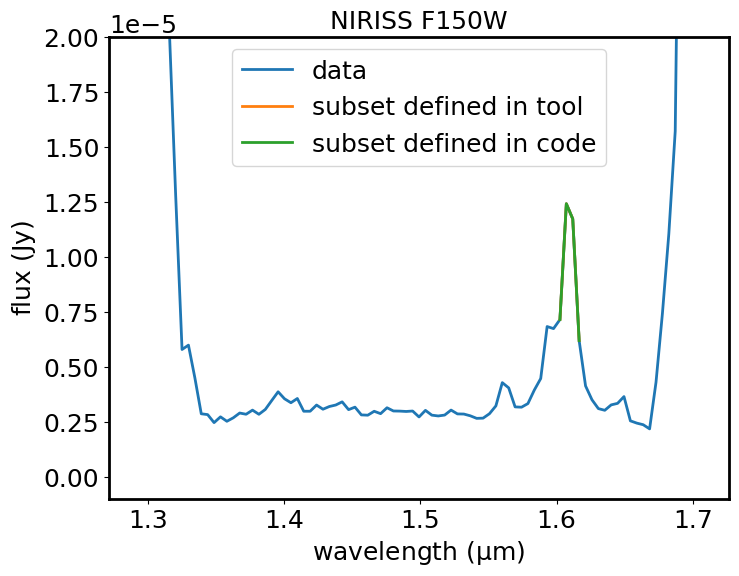

In [12]:
plt.plot(dataout.spectral_axis, dataout.flux, label='data')
plt.plot(spec1d_el_viz.spectral_axis, spec1d_el_viz.flux, label='subset defined in tool')
plt.plot(spec1d_el_code.spectral_axis, spec1d_el_code.flux, label='subset defined in code')
plt.legend()
plt.xlabel("wavelength ({:latex})".format(dataout.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(dataout.flux.unit))
plt.ylim(-1E-6, 2E-5)
plt.title("NIRISS F150W")
plt.show()

## 4. Use the redshift slider in Specviz to find the redshift

I can use an available line lists or define my own lines (I know I need Hb4862.68 and the [OIII]4960.29,5008.24 doublet) and play with the redshift slider to match the lines in the line list with the lines in the spectrum. The line list plugin can be found clicking the plugin icon on the upper right of the viewer. To input just the three lines, I can use the "Custom" menu.

Here is the documentation where line lists are explained: https://jdaviz.readthedocs.io/en/latest/specviz/plugins.html#line-lists

I can also define the lines of interest programmatically, as shown in the following cell.

In [13]:
lt = QTable()
lt['linename'] = ['Hb', '[OIII]1', '[OIII]2']
lt['rest'] = [4862.68, 4960.29, 5008.24]*u.AA

viz.load_line_list(lt)

The lines are not showing now because their rest value is outside the range plotted here. I can move the lines using the redshift slider in the line list plugin. It is best to first set the redshift to 2 in the box with the number and then move the slider to bring the lines on top of the observed emission lines.

### Get the redshift out in the Spectrum1D object

In [14]:
spec1d_redshift = viz.get_spectra(apply_slider_redshift=True)["NIRISS F150W"]
print(spec1d_redshift)

print()

if spec1d_redshift.redshift != 0.0:
    print("NIRISS F150W redshift=", spec1d_redshift.redshift)
else:
    print("Redshift was not defined in GUI. Defining it here.")
    spec1d_redshift.set_redshift_to(2.2138)
    print("NIRISS F150W redshift=", spec1d_redshift.redshift)

Spectrum1D (length=114)
Flux=[nan nan nan ... nan nan nan] Jy,  mean=0.00002 Jy
Spectral Axis=[1.76217806 1.75747955 1.75278091 ... 1.24063718 1.23593867
               1.23124003] um,  mean=1.49671 um
Uncertainty=StdDevUncertainty ([0. 0. 0. ... 0. 0. 0.] Jy)

Redshift was not defined in GUI. Defining it here.
NIRISS F150W redshift= 2.2138000000000004


## 5. Model the continuum of the spectrum

I can use the GUI to select the region where I see the continuum. _Challenge_: select a discontinuous subset that covers two intervals (1.35-1.55um and 1.63-1.65um). _Hint_: select "Add" at the top near the Subset dropdown.

I can then use the Model Fitting plugin under the plugin icon to fit a linear model to the selected region. Instructions can be found here: https://jdaviz.readthedocs.io/en/latest/specviz/plugins.html#model-fitting. The individual steps to complete this task are:
- Select Subset 1 under Data
- Select Linear1D or Polynomial (whatever you think is best) under Model
- Click Add Component
- Enter a name for the model under Output Data Label (I choose "continuum")
- Click Fit Model

I can extract the model and its parameters from the datasets in use.

In [15]:
datalabels = viz.data_labels
print(datalabels)
if 'continuum' in datalabels:
    spectrum = viz.get_data('NIRISS F150W')
    continuum = viz.get_data('continuum')
    print(continuum)
else:
    print("Continuum has not been created. Setting it to 0")
    spectrum = viz.get_data('NIRISS F150W')
    continuum = Spectrum1D(spectral_axis=spectrum.spectral_axis, flux=0.*spectrum.flux)

['NIRISS F150W']
Continuum has not been created. Setting it to 0


I can do a continuum subtraction and plot the result with matplotlib. If the continuum has not been defined in the GUI, this operation returns the original spectrum unchanged.

In [16]:
spectrum_sub = spectrum - continuum

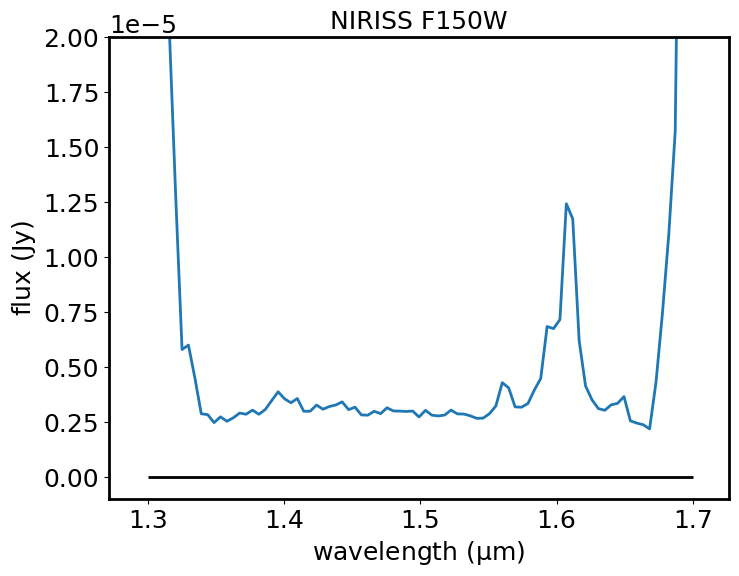

In [17]:
plt.plot(spectrum_sub.spectral_axis, spectrum_sub.flux)
plt.hlines(0, 1.3, 1.7, color='black')
plt.xlabel("wavelength ({:latex})".format(spectrum_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spectrum_sub.flux.unit))
plt.title("NIRISS F150W")
plt.ylim(-1E-6, 2E-5)
plt.show()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>